In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import itertools
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
import pickle
from numpy.random import shuffle

In [36]:
with open('../reviews.pkl', 'rb') as handle:
    data = pickle.load(handle)
titles = list(data.keys())
shuffle(titles)
train_titles = titles[:250]
test_titles = titles[250:]

In [37]:
reviews = []
ratings = []
vocab = []
lengths = []
review_counts = {}
for each_title in titles:
    r_pair = data[each_title]
    count = 0
    for each_pair in r_pair:
        if each_pair[1] != '0':
            reviews.append(each_pair[0])
            ratings.append(int(each_pair[1]))
            vocab += each_pair[0].split()
            lengths.append(len(each_pair[0].split()))
            count += 1
    review_counts[each_title] = count

In [38]:
vect = TfidfVectorizer(ngram_range = (1,2))
x_vect1 = vect.fit_transform(reviews)

In [39]:
movie_vec = {}
test_count = 0
train_count = 0
g_count = 0
for each_title in train_titles:
    movie_vec[each_title] = x_vect1[g_count : g_count+review_counts[each_title]]
    g_count += review_counts[each_title] 
    
train_count = g_count
for each_title in test_titles:
    movie_vec[each_title] = x_vect1[g_count : g_count+review_counts[each_title]]
    g_count += review_counts[each_title] 
test_count = g_count - train_count
print(train_count,test_count)

5240 934


In [40]:
def linsvc(x,y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state = 10)
    classf = LinearSVC(class_weight='balanced')
    classf.fit(x_train, y_train)
    pred = classf.predict(x_train)
    print("Linear SVC Train Accuracy:",accuracy_score(y_train, pred))
    pred = classf.predict(x_test)
    print("Linear SVC Test Accuracy:",accuracy_score(y_test, pred))
    return(y_test, pred, classf)

In [41]:
y = ratings
svmy1,svmp1,SVMclf = linsvc(x_vect1[:train_count],y[:train_count])

Linear SVC Train Accuracy: 1.0
Linear SVC Test Accuracy: 0.583969465648855


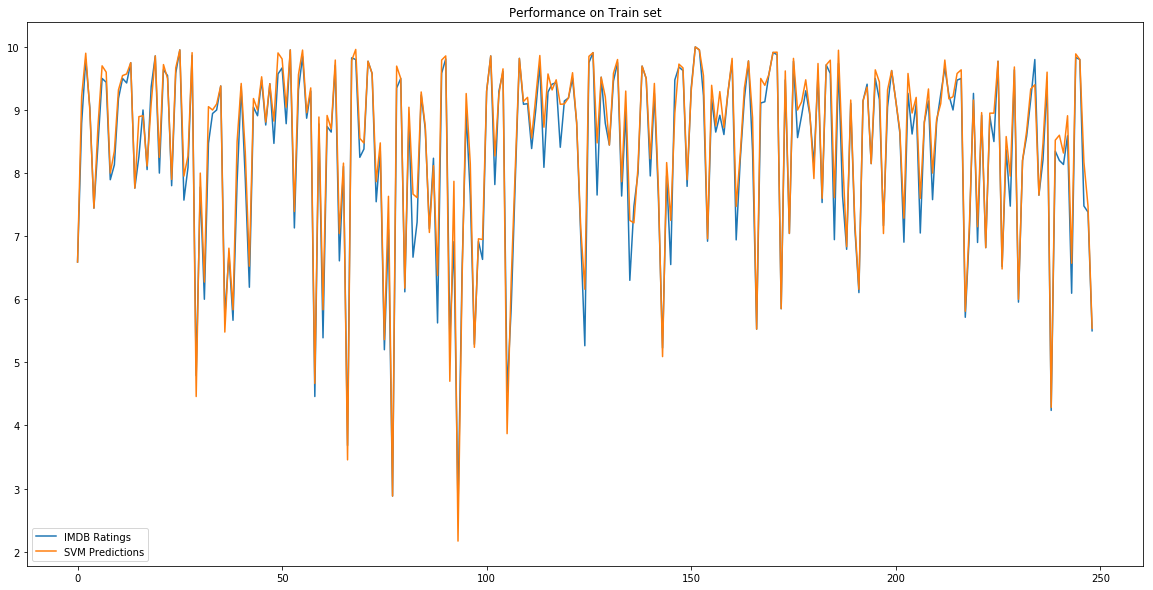

In [42]:
import statistics
import matplotlib.pyplot as plt

actual_ratings = []
predicted_ratings = []
for each_title in train_titles:
    rtgs = []
    for each_pair in data[each_title]:
        if each_pair[1] != '0':
            rtgs.append(int(each_pair[1]))
    if movie_vec[each_title].shape[0] > 1:
        svm_preds = SVMclf.predict(movie_vec[each_title])
        actual_ratings.append(statistics.mean(rtgs))
        predicted_ratings.append(np.mean(svm_preds))
#         print('Movie Title: ', each_title)
#         print('=====>Actual Rating:',statistics.mean(rtgs))
#         print('=====>SVM rating:',np.mean(svm_preds))
#         print('\n\n')

x = np.arange(len(actual_ratings))
plt.figure(figsize=(20,10))
plt.plot(x,actual_ratings,label='IMDB Ratings')
plt.plot(x,predicted_ratings,label='SVM Predictions')
plt.legend()
plt.title('Performance on Train set')
plt.show()

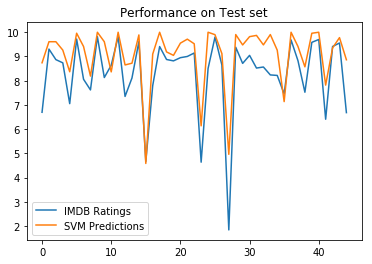

In [43]:
actual_ratings = []
predicted_ratings = []
for each_title in test_titles:
    rtgs = []
    for each_pair in data[each_title]:
        if each_pair[1] != '0':
            rtgs.append(int(each_pair[1]))
    if movie_vec[each_title].shape[0] > 1:
        svm_preds = SVMclf.predict(movie_vec[each_title])
        actual_ratings.append(statistics.mean(rtgs))
        predicted_ratings.append(np.mean(svm_preds))
#         print('Movie Title: ', each_title)
#         print('=====>Actual Rating:',statistics.mean(rtgs))
#         print('=====>SVM rating:',np.mean(svm_preds))
#         print('\n\n')

x = np.arange(len(actual_ratings))
plt.plot(x,actual_ratings,label='IMDB Ratings')
plt.plot(x,predicted_ratings,label='SVM Predictions')
plt.legend()
plt.title('Performance on Test set')
plt.show()

In [44]:
import pickle
pickle.dump(SVMclf, open('SVM.model', 'wb'))
pickle.dump(vect, open('vect.model', 'wb'))